# Final Presentation

Modify this notebook as the presentation notebook of your final presentation.

In [1]:
print("Hello world!")

Hello world!


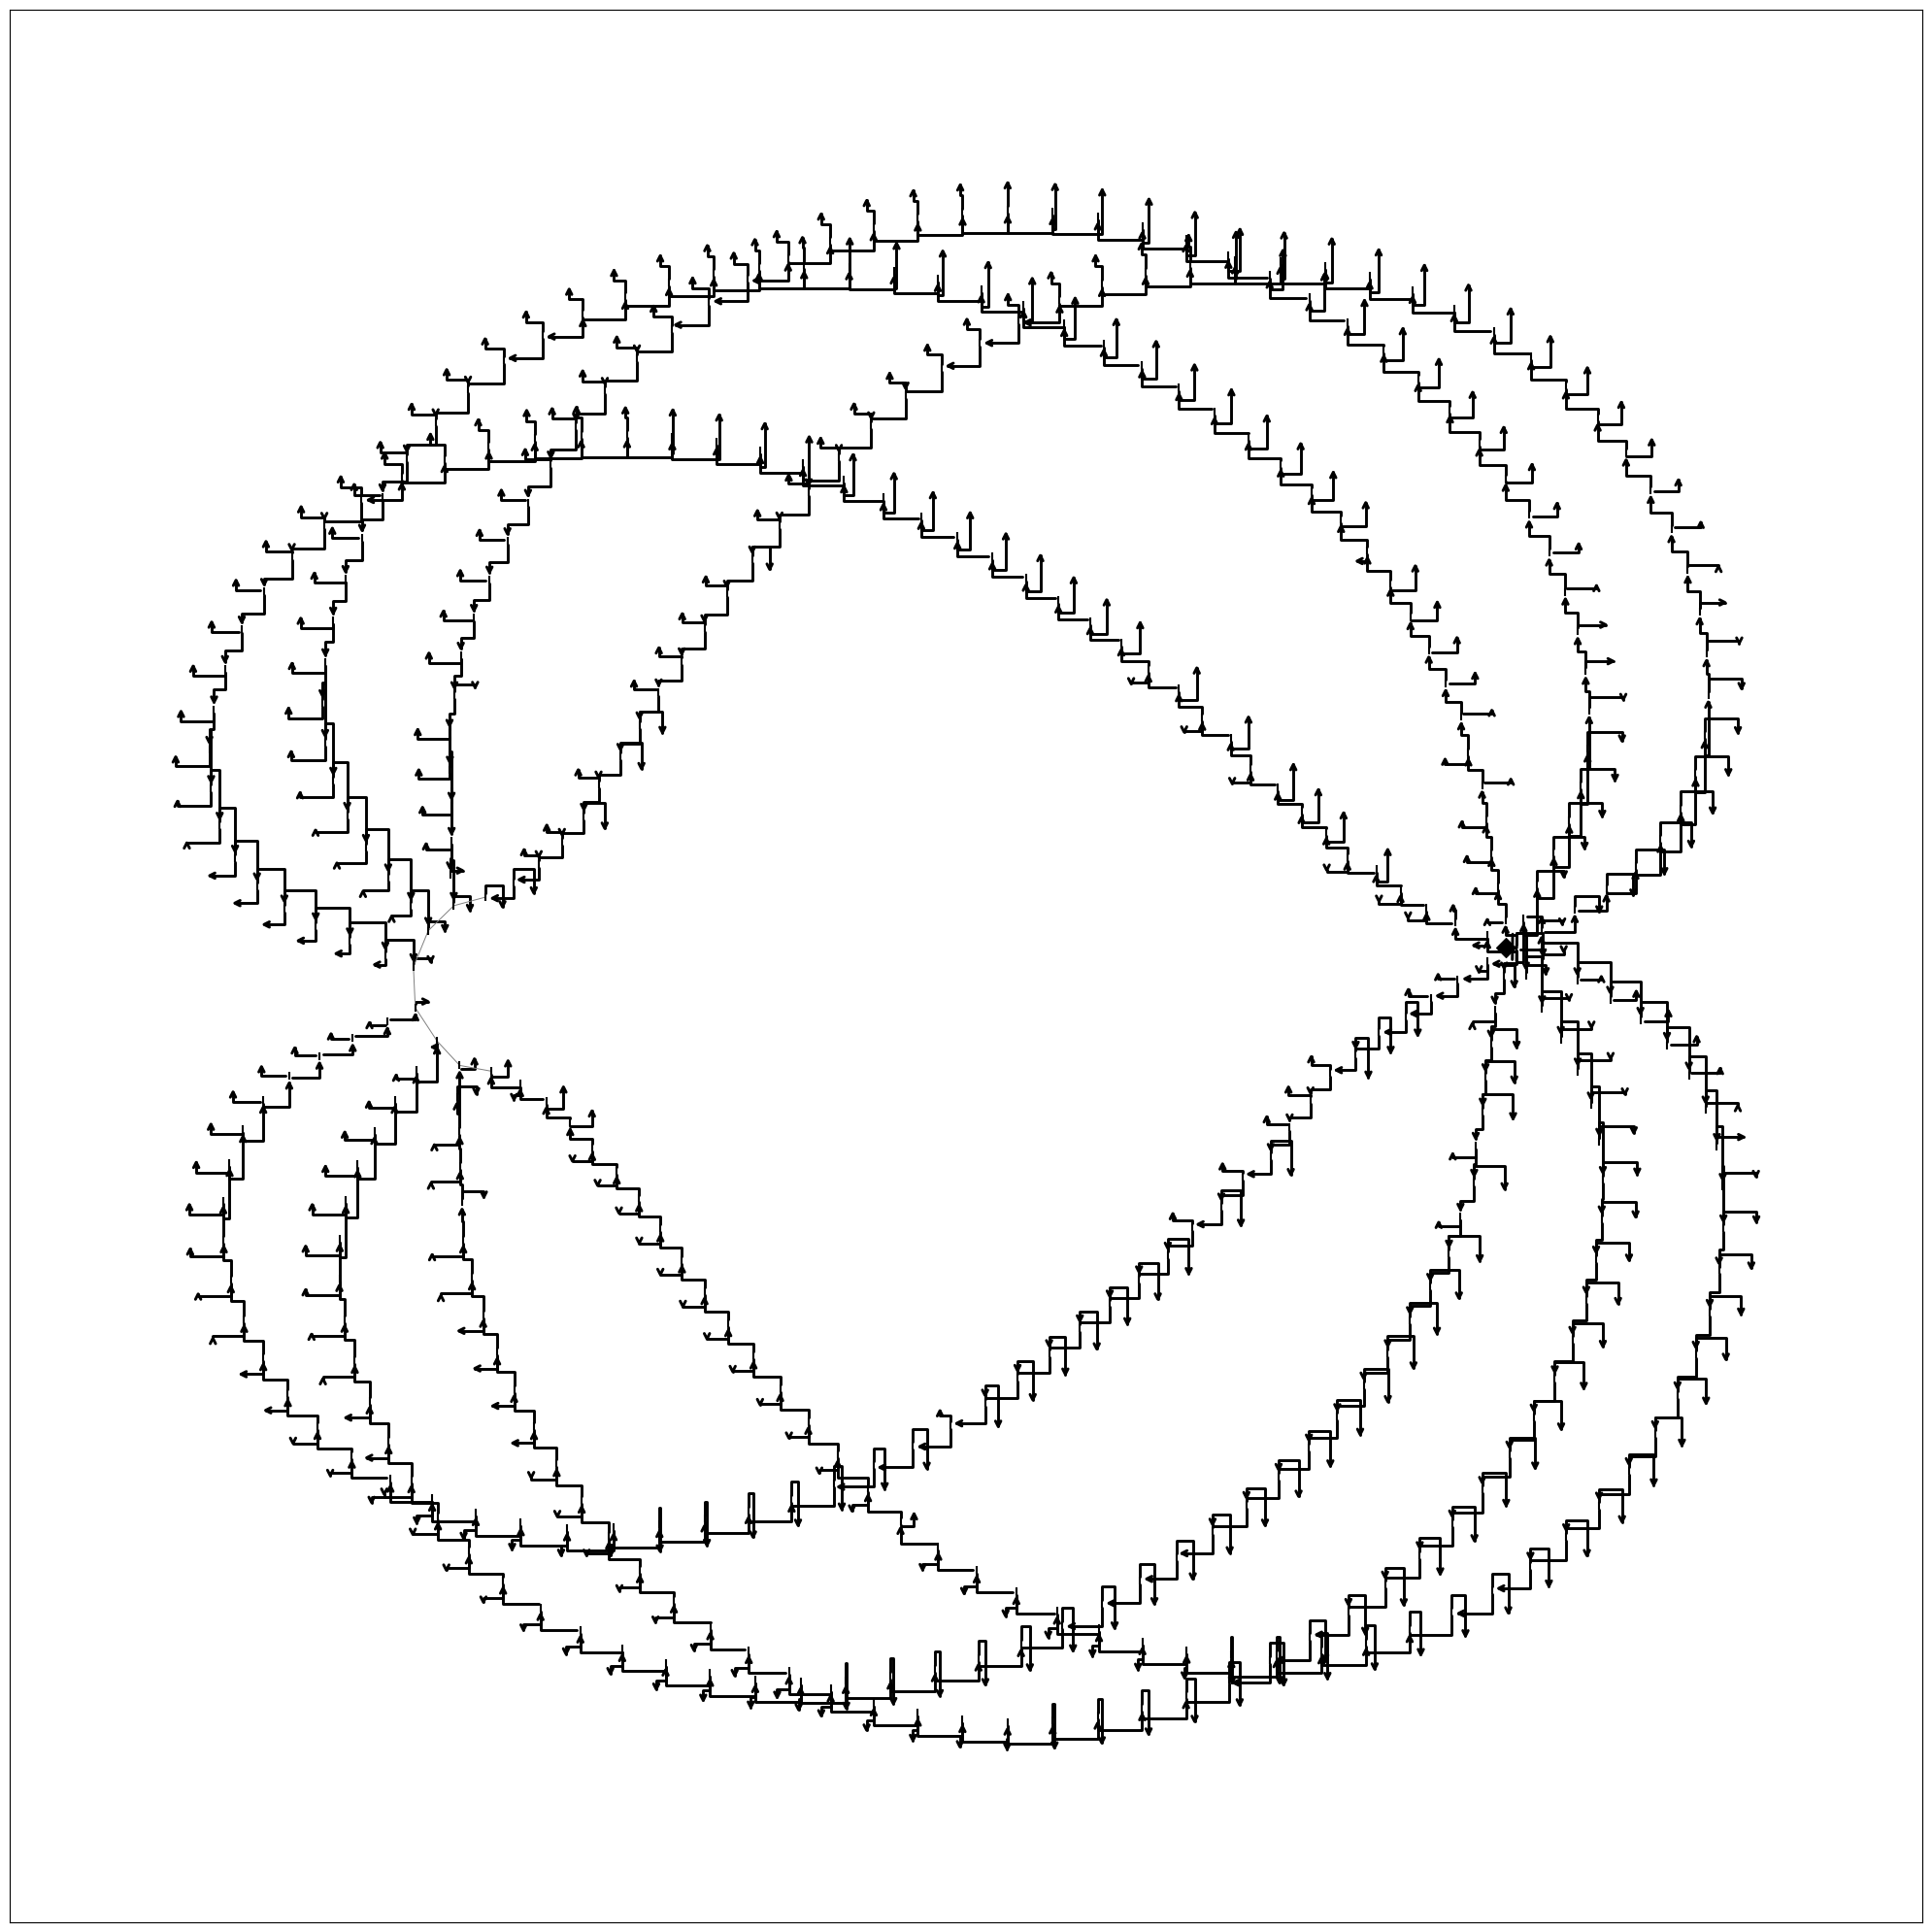

In [4]:
%matplotlib inline
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation, rc
from functools import partial

#%pip install power_grid_model

from power_grid_model.utils import json_deserialize, json_serialize

import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms

"""
import matplotlib.animation
import matplotlib.pyplot as plt
from itertools import count
import random
import time

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()
"""

with open('input_network_data.json') as fp:
    data = fp.read()
network_data = json_deserialize(data)

#aggregate_table = pd.read_parquet('calculated_output_per_timestamp.parquet')
aggregate_table = pd.read_parquet('calculated_output_per_line.parquet')

def __to_networkx_for_drawing(network_data):
  g = nx.Graph()
  if 'node' in network_data:
    # Add all nodes, based on "id".
    for node in network_data['node']:
      g.add_node(node[0], type='default')

  if 'line' in network_data:
    # Add all edges/lines, based on "from_node", "to_node".
    for line in network_data['line']:
      g.add_edge(line[1], line[2], id=line[0], type='default')
      if (line[3] == 0 or line[4] == 0):
        g.edges[line[1], line[2]].update({'enabled': False})
      else:
        g.edges[line[1], line[2]].update({'enabled': True})

  if 'transformer' in network_data:
    # Add transformer lines (these are separate in the data from the lines)
    for transformer in network_data['transformer']:
      g.add_edge(transformer[1], transformer[2], id=transformer[0], type='transformer')

  if 'sym_load' in network_data and 'source' in network_data:
    # Classify nodes based on source or load
    for sym_load in network_data['sym_load']:
      g.nodes[sym_load[1]].update({'type': 'sym_load'})
    for source in network_data['source']:
      g.nodes[source[1]].update({'type': 'source'})

  return g

#self.draw_aggregate_table
#self.draw_ax
#self.draw_g
draw_g = __to_networkx_for_drawing(network_data)
draw_aggregate_table = aggregate_table
fig, draw_ax = plt.subplots(figsize=(20,20))

def draw_animation_per_timestamp(frame):
  draw_ax.clear()
  # Frames start from 1
  frame = frame - 1

  # Local parameters (hard-coded)
  draw_node_size = 100
  draw_node_connecting_size = 33
  draw_line_width = 2.1
  draw_line_disabled_width = 0.7

  # Use planar node layout for all nodes to avoid edge intersections
  draw_pos = nx.planar_layout(draw_g)

  # Draw generic (connection) nodes
  draw_node_list = [key for key, value in nx.get_node_attributes(draw_g, 'type').items() if value == 'default']
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist=draw_node_list, pos=draw_pos, node_size = draw_node_connecting_size, label='Nodes', node_color='k')

  # Draw load nodes
  draw_node_list = [key for key, value in nx.get_node_attributes(draw_g, 'type').items() if value == 'sym_load']
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist=draw_node_list, pos=draw_pos, node_size = draw_node_size, node_shape = '>', label="Symmetrical Loads", node_color='k')

  # Draw source nodes
  draw_node_list = [key for key, value in nx.get_node_attributes(draw_g, 'type').items() if value == 'source']
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist=draw_node_list, pos=draw_pos, node_size = draw_node_size, node_shape = 'D', label="Sources", node_color='k')

  # Draw generic (connection) lines
  draw_edge_list = [key for key, value in nx.get_edge_attributes(draw_g, 'type').items() if value == 'default']
  # Pick enabled/disabled edges
  draw_edge_enabled_list = [key for key, value in nx.get_edge_attributes(draw_g, 'enabled').items() if value == True]
  nx.draw_networkx_edges(draw_g, ax=draw_ax, edgelist=draw_edge_enabled_list, pos=draw_pos, node_size = draw_node_connecting_size, width = draw_line_width, label="Lines", connectionstyle='angle,angleA=-90,angleB=180', arrows=True)
  draw_edge_enabled_list = [key for key, value in nx.get_edge_attributes(draw_g, 'enabled').items() if value == False]
  nx.draw_networkx_edges(draw_g, ax=draw_ax, edgelist=draw_edge_enabled_list, pos=draw_pos, node_size = draw_node_connecting_size, width = draw_line_disabled_width, edge_color='grey', label="Lines (disabled)")

  # Draw transformer lines
  draw_edge_list = [key for key, value in nx.get_edge_attributes(draw_g, 'type').items() if value == 'transformer']
  nx.draw_networkx_edges(draw_g, ax=draw_ax, edgelist=draw_edge_list, pos=draw_pos, node_size = draw_node_size, arrows=True, arrowstyle='|-|', style='dashed', width=draw_line_width, label="Transformer Lines")

  # Draw legend (doesn't work for transformer for some reason? Whatever)
  draw_ax.legend(loc=(1.04, 0))

  # Draw on-top, showing aggregate quantities of interest
  node_maxv = [int(draw_aggregate_table.iloc[frame, :]['Max_Voltage_Node'])]
  maxv = str(round(draw_aggregate_table.iloc[frame, :]['Max_Voltage'], 3))
  node_minv = [int(draw_aggregate_table.iloc[frame, :]['Min_Voltage_Node'])]
  minv = str(round(draw_aggregate_table.iloc[frame, :]['Min_Voltage'], 3))
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist = node_maxv, pos=draw_pos, node_size = 0.25*draw_node_size, node_shape = 's', label="Maximum Voltage Node", node_color='red')
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist = node_minv, pos=draw_pos, node_size = 0.25*draw_node_size, node_shape = 's', label="Minimum Voltage Node", node_color='green')
  # Bbox doesnt work: nx.draw_networkx_labels(g, ax=ax, pos=draw_pos, labels={node_maxv[0]: maxv, node_minv[0]: minv}, bbox=Bbox.from_bounds(1, 1, 2, 3))
  nx.draw_networkx_labels(draw_g, ax=draw_ax, pos=draw_pos, labels={node_maxv[0]: maxv, node_minv[0]: minv})

  # Draw on top, TimeStamp title
  draw_ax.set_title("Time: " + str(draw_aggregate_table.index[frame]))
  bbox = draw_ax.get_position()
  draw_ax.set_position([bbox.x0, bbox.y0, 0.5, bbox.height])

  return

def draw_per_line():
  draw_ax.clear()
  # Local parameters (hard-coded)
  draw_node_size = 100
  draw_node_connecting_size = 33
  draw_line_width = 2.1
  draw_line_disabled_width = 0.7

  # Use planar node layout for all nodes to avoid edge intersections
  draw_pos = nx.kamada_kawai_layout(draw_g)

  # Draw generic (connection) nodes
  draw_node_list = [key for key, value in nx.get_node_attributes(draw_g, 'type').items() if value == 'default']
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist=draw_node_list, pos=draw_pos, node_size = draw_node_connecting_size, node_shape='|', label='Nodes', node_color='k')

  # Draw load nodes
  draw_node_list = [key for key, value in nx.get_node_attributes(draw_g, 'type').items() if value == 'sym_load']
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist=draw_node_list, pos=draw_pos, node_size = 0, node_shape = '>', label="Symmetrical Loads", node_color='k')

  # Draw source nodes
  draw_node_list = [key for key, value in nx.get_node_attributes(draw_g, 'type').items() if value == 'source']
  nx.draw_networkx_nodes(draw_g, ax=draw_ax, nodelist=draw_node_list, pos=draw_pos, node_size = draw_node_size, node_shape = 'D', label="Sources", node_color='k')

  # Draw generic (connection) lines
  draw_edge_list = [key for key, value in nx.get_edge_attributes(draw_g, 'type').items() if value == 'default']
  # Pick enabled/disabled edges
  draw_edge_enabled_list = [key for key, value in nx.get_edge_attributes(draw_g, 'enabled').items() if value == True]
  nx.draw_networkx_edges(draw_g, ax=draw_ax, edgelist=draw_edge_enabled_list, pos=draw_pos, node_size = draw_node_connecting_size, width = draw_line_width, label="Lines", connectionstyle='bar,angle=-180,fraction=-0.5', arrows=True, arrowstyle='->')
  draw_edge_enabled_list = [key for key, value in nx.get_edge_attributes(draw_g, 'enabled').items() if value == False]
  nx.draw_networkx_edges(draw_g, ax=draw_ax, edgelist=draw_edge_enabled_list, pos=draw_pos, node_size = draw_node_connecting_size, width = draw_line_disabled_width, edge_color='grey', label="Lines (disabled)")

  # Draw transformer lines
  draw_edge_list = [key for key, value in nx.get_edge_attributes(draw_g, 'type').items() if value == 'transformer']
  nx.draw_networkx_edges(draw_g, ax=draw_ax, edgelist=draw_edge_list, pos=draw_pos, node_size = draw_node_size, arrows=True, arrowstyle='|-|', style='dashed', width=draw_line_width, label="Transformer Lines")

  # Draw on-top, showing aggregate quantities of interest
  draw_edge_label_dict = {}
  #print(nx.get_edge_attributes(draw_g, 'id'))
  #print([key for key in nx.get_edge_attributes(draw_g, 'id').keys()])
  #print([value for value in nx.get_edge_attributes(draw_g, 'id').values()])
  line_values = [value for value in nx.get_edge_attributes(draw_g, 'id').values()]
  #print(draw_aggregate_table.loc[draw_aggregate_table.index.isin([value for value in nx.get_edge_attributes(draw_g, 'id').values()])])
  #print([value for key, value in nx.get_edge_attributes(draw_g, 'id').items()])
  for i1 in line_values:
    for i2 in draw_aggregate_table.index:
      if i1 == i2:
        str_descriptor = "MAX: " + str(round(draw_aggregate_table.loc[i1, 'Max_Loading'], 3)) + " AT: " + str(draw_aggregate_table.loc[i1, 'Max_Loading_Timestamp'])
        print([value for key, value in nx.get_edge_attributes(draw_g, 'id').items() if value==i1])
        draw_edge_label_dict.update({[key for key, value in nx.get_edge_attributes(draw_g, 'id').items() if value==i1][0]: str_descriptor})
 # print(draw_edge_label_dict)
  #draw_edge_label_dict = {[key for key in nx.get_edge_attributes(draw_g, 'type').keys]: str("a")}
  nx.draw_networkx_edge_labels(draw_g, ax = draw_ax, pos = draw_pos, edge_labels = draw_edge_label_dict, font_size=5, horizontalalignment='center', verticalalignment='bottom', font_color = 'red', rotate=False)
  for i1 in line_values:
    for i2 in draw_aggregate_table.index:
      if i1 == i2:
        str_descriptor = "MIN: " + str(round(draw_aggregate_table.loc[i1, 'Min_Loading'], 3)) + " AT: " + str(draw_aggregate_table.loc[i1, 'Min_Loading_Timestamp'])
        print([value for key, value in nx.get_edge_attributes(draw_g, 'id').items() if value==i1])
        draw_edge_label_dict.update({[key for key, value in nx.get_edge_attributes(draw_g, 'id').items() if value==i1][0]: str_descriptor})
  #print(draw_edge_label_dict)
  #draw_edge_label_dict = {[key for key in nx.get_edge_attributes(draw_g, 'type').keys]: str("a")}
  draw_pos_lower = {}
  for key, value in draw_pos.items():
    draw_pos_lower[key] = [value[0], -0.02 + value[1]]
  nx.draw_networkx_edge_labels(draw_g, ax = draw_ax, pos = draw_pos_lower, edge_labels = draw_edge_label_dict, font_size=5, horizontalalignment='center', verticalalignment='top', font_color = 'blue', rotate=False)
  for i1 in line_values:
    for i2 in draw_aggregate_table.index:
      if i1 == i2:
        str_descriptor = "TOTAL LOSS: " + str(round(draw_aggregate_table.loc[i1, 'Total_Loss'], 3))
        print([value for key, value in nx.get_edge_attributes(draw_g, 'id').items() if value==i1])
        draw_edge_label_dict.update({[key for key, value in nx.get_edge_attributes(draw_g, 'id').items() if value==i1][0]: str_descriptor})
 # print(draw_edge_label_dict)
  #draw_edge_label_dict = {[key for key in nx.get_edge_attributes(draw_g, 'type').keys]: str("a")}
  #fbbox = matplotlib.transforms.Bbox.from_bounds(0, 0, 1, 1)
  fbbox = {"boxstyle": "square", "ec": (1.0, 1.0, 1.0), "fc": (1.0, 1.0, 1.0)}
  #draw_pos_higher = {x: [x[0] + 1, x[1] + 1] for x in draw_pos}
  draw_pos_center = {}
  for key, value in draw_pos.items():
    draw_pos_center[key] = [value[0], -0.01 + value[1]]
  #print(test)
  nx.draw_networkx_edge_labels(draw_g, ax = draw_ax, pos = draw_pos_center, edge_labels = draw_edge_label_dict, font_size=5, horizontalalignment='center', verticalalignment='center', font_color = 'black', rotate=False, bbox = fbbox)
  
  plt.tight_layout()
  plt.show()

  return


# add self later (draw_aggregate_result(self, ...))
def draw_aggregate_result(network_data, aggregate_table: pd.DataFrame, type: str):
  figsize_x = 6
  figsize_y = 4
  # In ms
  anim_interval = 1000
  g = __to_networkx_for_drawing(network_data)
  draw_g = g
  draw_aggregate_table = aggregate_table.copy()
  match type:
    case 'per_line':
      print(aggregate_table)
    case 'per_timestamp':
      #fig, draw_ax = plt.subplots(figsize=(figsize_x,figsize_y))
      #ani =
      #matplotlib.animation.ArtistAnimation(fig, artists = __draw_animation_per_timestamp(g, aggregate_table, ax), interval=400)
      # ani =
      #anim.FuncAnimation(fig, func=partial(__draw_animation_per_timestamp, g=g, aggregate_table=aggregate_table, ax=ax), frames=aggregate_table.index.size, interval=anim_interval, repeat=False, blit=True)
      #__draw_update_per_timestamp(1, g, aggregate_table, ax)
      #animation = matplotlib.animation.FuncAnimation(fig, draw_animation_per_timestamp, frames=5, interval=50, cache_frame_data=False)
      #__draw_animation_per_timestamp(0)
      #for frames in range(1, aggregate_table.index.size):
       # ax = __draw_animation_per_timestamp(frames, g, aggregate_table, ax)
       # time.sleep(1)
       # plt.plot(ax=ax)
      rc('animation', html='jshtml')
      animation
      plt.show()

    case 'n-1':
      print('c')
    case _:
      raise ValueError()


#draw_aggregate_result(network_data, aggregate_table, 'per_timestamp')
#animation = matplotlib.animation.FuncAnimation(fig, draw_animation_per_timestamp, frames=aggregate_table.index.size, interval=1000, cache_frame_data=False)
#animation

draw_per_line()
#print(aggregate_table)
